## Importing Libraries

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import tensorflow as tf
import joblib

##### Creating environment to train the model

In [19]:
print(tf.test.is_built_with_cuda())

True


In [6]:
# Import csv file
csv_file = "resources/model1.csv"
df_balanced = pd.read_csv(csv_file)

# Create a list which includes only the reviews
reviews = df_balanced['text']
reviews

0         We were here yesterday for a bachelorette part...
1         4-stars for food, 2-stars for service.  I'm pr...
2         The store itself is so iconic, don't let the t...
3         every single dessert looked so yummy and tempt...
4         First time visit today, 12-27-21, when visitin...
                                ...                        
191379    There are so many reasons not to go. But for n...
191380    This place......this place sold me a used shav...
191381    The food is good..when its what you actually o...
191382    This place is really starting to go down hill....
191383    Simple review\n\nDecent food. Horrible service...
Name: text, Length: 191384, dtype: object

## Embeddings
##### Here we have used 'all-miniLm-L6-v2' embedding model in hugging face to embed our text data into 384 dimensions. After that we have normalized our embeddings.

In [7]:
# Create instance of embeddings
embeddings = SentenceTransformer('all-MiniLM-L6-v2')

In [8]:
# Embed reviews
review_embeddings = embeddings.encode(reviews)

In [9]:
# Normalize the embeddings to unit length
corpus_embeddings = review_embeddings /  np.linalg.norm(review_embeddings, axis=1, keepdims=True)
corpus_embeddings[0]

array([ 2.41557620e-02,  9.08891577e-03,  3.22492234e-02,  1.46426596e-02,
       -2.63296962e-02,  5.12173325e-02,  1.08727412e-02, -3.79333906e-02,
       -2.75214408e-02,  7.84197450e-03,  8.96113086e-03,  4.43134047e-02,
       -1.61689483e-02, -4.90075983e-02,  3.15023251e-02,  1.18168285e-02,
        9.32630673e-02, -4.05295901e-02, -3.27605903e-02,  4.98124249e-02,
       -9.40259919e-02, -1.34407729e-01,  4.41048816e-02,  5.57920970e-02,
        1.09498631e-02, -8.79888237e-02,  1.70827918e-02, -4.22589369e-02,
       -5.24938330e-02, -4.12021242e-02,  5.73192835e-02,  7.52092972e-02,
        2.19715461e-02, -1.97378602e-02,  1.95112806e-02, -3.10663618e-02,
        1.93819068e-02, -8.99232924e-02, -2.07906403e-02,  1.07103445e-01,
       -7.29529493e-05,  3.48936543e-02, -9.88079533e-02,  4.50416505e-02,
        4.15993482e-02,  3.79793271e-02,  8.56010541e-02,  4.79640514e-02,
        1.85738597e-02,  6.23932071e-02,  7.33202621e-02,  2.23782435e-02,
        2.39443649e-02, -

In [10]:
# Split data into training and validation sets
X_train, X_val = train_test_split(corpus_embeddings, test_size=0.1, random_state=42)

## Defining the models architecture
##### Layers used are as below
* Input Layer
* Dense Layer with ReLU
* Dense Layer with Softmax
##### Model compilation details are as below
* Optimizer - Adam
* Loss Function - mean square error

In [14]:
# Define an autoencoder model
input_dim = X_train.shape[1]
encoding_dim = 64

input_layer = tf.keras.layers.Input(shape=(input_dim,))
encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(input_layer)
decoded = tf.keras.layers.Dense(input_dim, activation='softmax')(encoded)

METRICS = [
    tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')
]

autoencoder = tf.keras.Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics='accuracy')

##### Training the model

In [15]:
# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=10, batch_size=16, shuffle=True, validation_data=(X_val, X_val))

Epoch 1/10
10766/10766 [==============================] - 52s 5ms/step - loss: 0.0023 - accuracy: 0.4751 - val_loss: 0.0023 - val_accuracy: 0.5493
Epoch 2/10
10766/10766 [==============================] - 53s 5ms/step - loss: 0.0023 - accuracy: 0.5570 - val_loss: 0.0023 - val_accuracy: 0.5641
Epoch 3/10
10766/10766 [==============================] - 50s 5ms/step - loss: 0.0023 - accuracy: 0.5754 - val_loss: 0.0023 - val_accuracy: 0.5751
Epoch 4/10
10766/10766 [==============================] - 50s 5ms/step - loss: 0.0023 - accuracy: 0.5818 - val_loss: 0.0023 - val_accuracy: 0.5804
Epoch 5/10
10766/10766 [==============================] - 49s 5ms/step - loss: 0.0023 - accuracy: 0.5831 - val_loss: 0.0023 - val_accuracy: 0.5686
Epoch 6/10
10766/10766 [==============================] - 49s 5ms/step - loss: 0.0023 - accuracy: 0.5804 - val_loss: 0.0023 - val_accuracy: 0.5942
Epoch 7/10
10766/10766 [==============================] - 50s 5ms/step - loss: 0.0023 - accuracy: 0.5805 - val_loss: 0

In [23]:
# Use the trained autoencoder to encode the data
encoded_reviews = autoencoder.predict(corpus_embeddings, batch_size=8)

23923/23923 [==============================] - 34s 1ms/step


In [24]:
# Standardize the encoded data
scaler = StandardScaler()
encoded_reviews = scaler.fit_transform(encoded_reviews)

## Clustering
##### To cluster the encoded data we are using K-means clustering. Before that to get an idea about the number of suitable clusters we are using 'Silhouette score' to analyse the clustering

C:\Users\workspace\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\workspace\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\workspace\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


For K=2, Silhouette Score: 0.06513085216283798


C:\Users\workspace\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For K=3, Silhouette Score: 0.05066546052694321


C:\Users\workspace\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For K=4, Silhouette Score: 0.029411526396870613


C:\Users\workspace\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For K=5, Silhouette Score: 0.018917128443717957


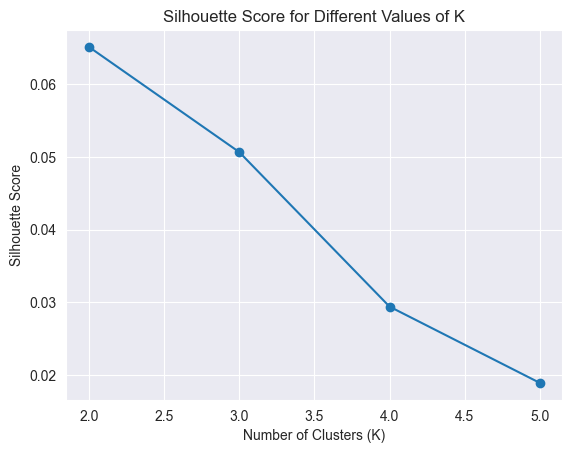

In [14]:
# Finding best value for K using silhouette coefficient
silhouette_scores = []

for k in range(2, 6):  # Adjust the range as needed
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(corpus_embeddings)
    silhouette_avg = silhouette_score(corpus_embeddings, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For K={k}, Silhouette Score: {silhouette_avg}")

# Plotting the silhouette scores
plt.plot(range(2, 6), silhouette_scores, marker='o')
plt.title('Silhouette Score for Different Values of K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

In [25]:
# Training the K-Means clustering model
clustering_model = KMeans(n_clusters=4)
clustering_model.fit(encoded_reviews)

C:\Users\workspace\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\workspace\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\workspace\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


KMeans(n_clusters=4)

## Model Evaluation
##### To evaluate our model we have used below techniques,
* 3D Visualization of clusters
* 2D Visualization of clusters
* Inertia
* Davis Bouldin score
* Calinski Harabasz score

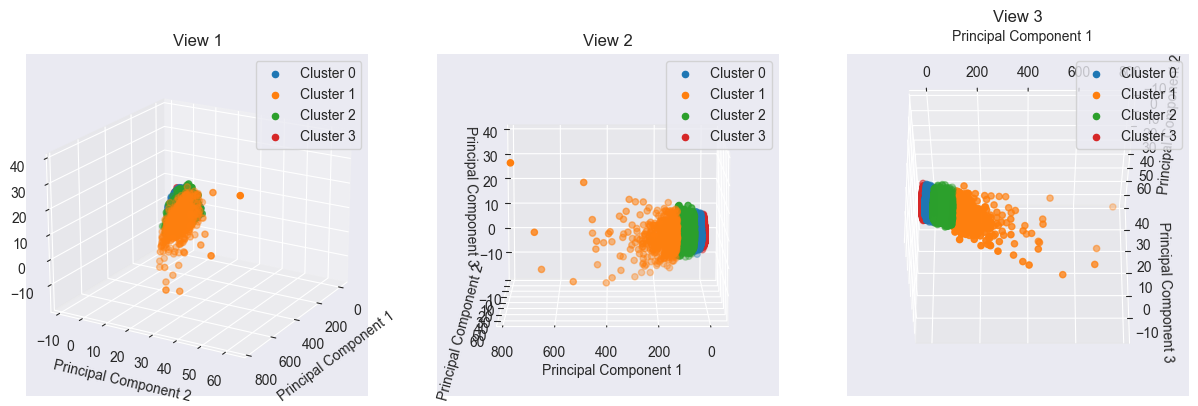

In [26]:
# Fit the PCA model to reduce dimensionality to 3
pca = PCA(n_components=3)
pca_result = pca.fit_transform(encoded_reviews)

# Add cluster labels to the PCA results
pca_result_with_labels = np.column_stack((pca_result, clustering_model.labels_))

# Create a 3D scatter plot with multiple views
fig = plt.figure(figsize=(15, 5))

# Plot 1
ax1 = fig.add_subplot(131, projection='3d')
for label in set(clustering_model.labels_):
    indices = np.where(pca_result_with_labels[:, -1] == label)
    ax1.scatter(pca_result_with_labels[indices, 0], pca_result_with_labels[indices, 1], pca_result_with_labels[indices, 2], label=f'Cluster {label}')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.set_zlabel('Principal Component 3')
ax1.set_title('View 1')
ax1.legend()
ax1.view_init(elev=20, azim=30)  # Adjust the elevation (elev) and azimuth (azim) angles

# Plot 2
ax2 = fig.add_subplot(132, projection='3d')
for label in set(clustering_model.labels_):
    indices = np.where(pca_result_with_labels[:, -1] == label)
    ax2.scatter(pca_result_with_labels[indices, 0], pca_result_with_labels[indices, 1], pca_result_with_labels[indices, 2], label=f'Cluster {label}')
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.set_zlabel('Principal Component 3')
ax2.set_title('View 2')
ax2.legend()
ax2.view_init(elev=10, azim=90)  # Adjust the elevation (elev) and azimuth (azim) angles

# Plot 3
ax3 = fig.add_subplot(133, projection='3d')
for label in set(clustering_model.labels_):
    indices = np.where(pca_result_with_labels[:, -1] == label)
    ax3.scatter(pca_result_with_labels[indices, 0], pca_result_with_labels[indices, 1], pca_result_with_labels[indices, 2], label=f'Cluster {label}')
ax3.set_xlabel('Principal Component 1')
ax3.set_ylabel('Principal Component 2')
ax3.set_zlabel('Principal Component 3')
ax3.set_title('View 3')
ax3.legend()
ax3.view_init(elev=-30, azim=-90)  # Adjust the elevation (elev) and azimuth (azim) angles

plt.show()

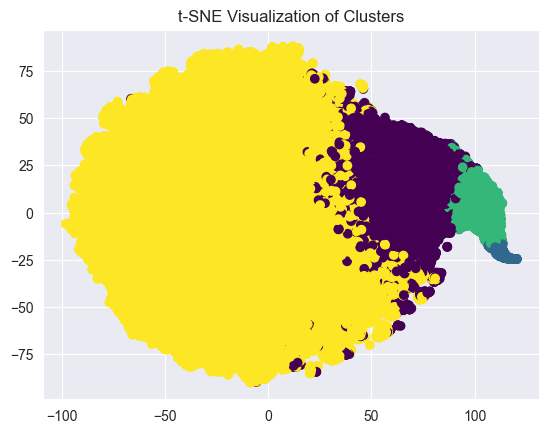

In [27]:
# 2D Visualization
tsne = TSNE(n_components=2, random_state=42)
embedded_clusters = tsne.fit_transform(encoded_reviews)

plt.scatter(embedded_clusters[:, 0], embedded_clusters[:, 1], c=clustering_model.labels_, cmap='viridis')
plt.title("t-SNE Visualization of Clusters")
plt.show()

In [28]:
# Inertia
inertia = clustering_model.inertia_
print(f"Inertia: {inertia}")

Inertia: 25280786.0


In [29]:
# Davies Bouldin Score
db_index = davies_bouldin_score(encoded_reviews, clustering_model.labels_)
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 0.9577129081984078


In [30]:
# Calinski Harabasz Score
ch_index = calinski_harabasz_score(encoded_reviews, clustering_model.labels_)
print(f"Calinski-Harabasz Index: {ch_index}")

Calinski-Harabasz Index: 121654.16447343038


In [32]:
# Writing all miniLm embeddings to a CSV file
df_embed = pd.DataFrame(review_embeddings)
df_embed

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,0.024156,0.009089,0.032249,0.014643,-0.026330,0.051217,0.010873,-0.037933,-0.027521,0.007842,...,0.066228,0.022519,0.019617,0.027336,0.159229,0.055086,-0.057367,-0.008627,-0.085154,-0.031364
1,-0.041754,0.018263,0.039627,-0.004721,-0.046235,-0.070280,0.099042,-0.073399,0.054763,-0.076885,...,0.072902,-0.083955,0.045834,0.033454,0.037068,0.021928,-0.043214,0.005771,-0.163063,-0.018822
2,0.005861,0.001859,0.040535,0.018567,-0.081135,-0.040049,-0.007888,-0.008679,-0.018534,-0.117283,...,0.021023,-0.014220,-0.029890,-0.007436,0.074372,0.032473,-0.007149,-0.048853,-0.086009,-0.013019
3,0.033380,-0.042361,0.005619,0.009471,-0.047507,0.030676,0.018747,-0.046940,0.019145,-0.031987,...,0.016918,-0.024109,-0.006980,-0.055531,0.039780,0.081617,0.097650,0.010663,-0.082075,-0.054842
4,0.006533,-0.014577,0.018837,0.011880,-0.065679,-0.018051,-0.041679,-0.069794,-0.020485,-0.010493,...,0.000518,0.077449,-0.023396,-0.021780,0.067175,0.027126,0.029822,0.065756,-0.131317,-0.008376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191379,0.027287,-0.026534,0.027785,-0.047409,-0.022688,-0.039839,-0.027797,-0.081601,0.026401,-0.059050,...,0.002289,0.038615,-0.051261,-0.048695,0.082788,-0.000328,-0.025111,-0.005377,-0.013688,-0.004802
191380,0.059438,0.006780,0.066102,0.041159,-0.021505,-0.025972,0.055769,0.013482,-0.026079,-0.025455,...,0.019848,-0.020488,-0.029802,-0.079992,-0.040192,0.060471,0.059831,-0.127221,-0.023632,0.075163
191381,-0.020800,0.044430,0.065514,0.060358,-0.112837,-0.001920,-0.006944,-0.096528,-0.025135,-0.048407,...,-0.014219,-0.020311,0.094110,-0.010113,0.080935,-0.014924,-0.034246,0.007152,-0.117320,0.008210
191382,0.057305,0.060774,0.040477,0.053650,-0.042306,-0.049373,0.001867,-0.010995,-0.034605,-0.100153,...,0.039590,0.009483,0.045201,-0.049078,0.003892,0.052236,0.032674,0.006340,-0.118897,0.057401


In [33]:
df_embed.to_csv('resources/miniLm-embeddings.csv', index=False)

In [36]:
# Saving the model
joblib.dump(clustering_model, 'saved_models/model1.joblib')

['saved_models/model1.joblib']

In [37]:
autoencoder.save('saved_models/autoencoder.h5')